# **Harris Corner Detector**

Corner detection is a fundamental aspect of computer vision and the Harris Corner Detector is a simple yet highly relevant corner detection method. In this notebook, we will learn how to implement Harris Corner Detection from scratch on several test images so that we can gain a full understanding of it.

The general algorithm is: <br>
    $\quad$ 1. Compute the horizontal and vertical image derivatives <br>
    $\quad$ 2. Compute the product of the derivatives (dx*dx, dy*dy, dx*dy) <br> 
    $\quad$ 3. Convolve a Gaussian Smoothing kernel with each of the product derivatives → Any type of blurring should help reduce noise <br>
    $\quad$ 4. Compute Corner Response: R = (AB — C²) — k (A + B)² <br>
    $\quad$ 5. Threshold Corner Response to get strong corners: R > thresh <br>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

Create Test Images

In [2]:
N = 256 # image size

awgn = np.random.normal(0, 0.1, (N, N))
flat_image = np.zeros((N, N))

horz_image = flat_image.copy()
horz_image[0:N//2, :] = 1 # 255

vert_image = flat_image.copy()
vert_image[:, 0:N//2] = 1 # 255

corner = flat_image.copy()
corner[0:N//2, 0:N//2] = 1 # 255

blunt_corner = flat_image.copy()
pts = np.array([(0,0), (0, N//2+30), (N//2, N//2), (N, 0)]).reshape((-1, 1, 2))
cv2.fillPoly(blunt_corner, [pts], color=(1,))

sharp_corner = flat_image.copy()
tri_pts = np.array([(0,0), (0, N//2-50), (N//2, N//2)]).reshape((-1, 1, 2))
cv2.fillPoly(sharp_corner, [tri_pts], color=(1,))


# add  noise and 0-1 normalize
flat_image += awgn
horz_image += awgn
vert_image += awgn
corner += awgn
blunt_corner += awgn
sharp_corner += awgn

flat_image /= flat_image.max()
horz_image /= horz_image.max()
vert_image /= vert_image.max()
corner /= corner.max()
blunt_corner /= blunt_corner.max()
sharp_corner /= sharp_corner.max()

Display test images

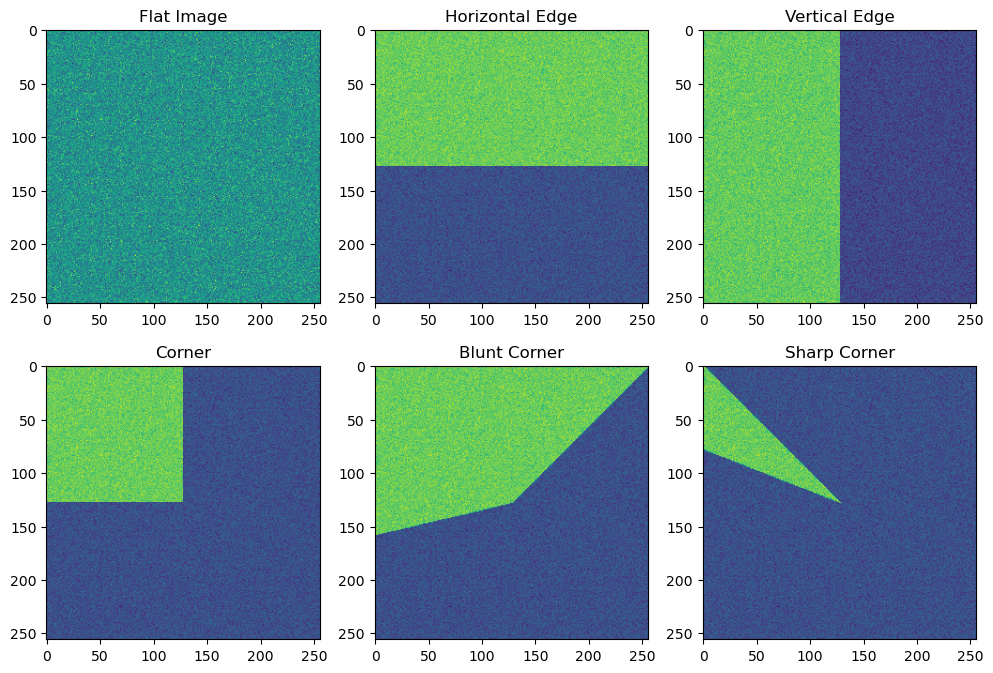

In [3]:
_, ax = plt.subplots(2, 3, figsize=(12, 8))
ax[0, 0].imshow(flat_image)
ax[0, 0].set_title("Flat Image")

ax[0, 1].imshow(horz_image)
ax[0, 1].set_title("Horizontal Edge")

ax[0, 2].imshow(vert_image)
ax[0, 2].set_title("Vertical Edge")

ax[1, 0].imshow(corner)
ax[1, 0].set_title("Corner")

ax[1, 1].imshow(blunt_corner)
ax[1, 1].set_title("Blunt Corner")

ax[1, 2].imshow(sharp_corner)
ax[1, 2].set_title("Sharp Corner");

# **Harris Corner Detection Pipeline**

Now we will create a pipeline to implement Harris Corner Detection from scratch. In this notebook, we will only compute the corner response from scratch and use opencv functions to find the best corners based on the Harriso corner response.

<br>

First we will need to set some hyperparameters for the Harris detection. 

In [4]:
k = 0.05
thresh = 0.5

We will also set up Sobel Kernels to compute the first derivatives of the image as well as a Gaussian Kernel to handle the Gaussian Windowing. We will also compare the Gaussian Window to the block window and see how the noise is reduced.

In [5]:
# Sobel kernels
Sx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]])

Sy = Sx.T

# Gaussian Kernel
G = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])/16

Now construct the pipeline function

In [6]:
def corner_response(image, k=k):
    # compute first derivatives
    dx = cv2.filter2D(image, ddepth=-1, kernel=Sx)
    dy = cv2.filter2D(image, ddepth=-1, kernel=Sy)

    # Gaussian Filter
    A = cv2.filter2D(dx*dx, ddepth=-1, kernel=G)
    B = cv2.filter2D(dy*dy, ddepth=-1, kernel=G)
    C = cv2.filter2D(dx*dy, ddepth=-1, kernel=G)

    # compute corner response at all pixels
    return (A*B - (C*C)) - k*(A + B)*(A + B)

### Compute Corner Response for all images

In [7]:
R_flat = corner_response(flat_image)
R_horz = corner_response(horz_image)
R_vert = corner_response(vert_image)
R_corner = corner_response(corner)
R_blunt_corner = corner_response(blunt_corner)
R_sharp_corner = corner_response(sharp_corner)

Text(0.5, 1.0, 'Sharp Corner')

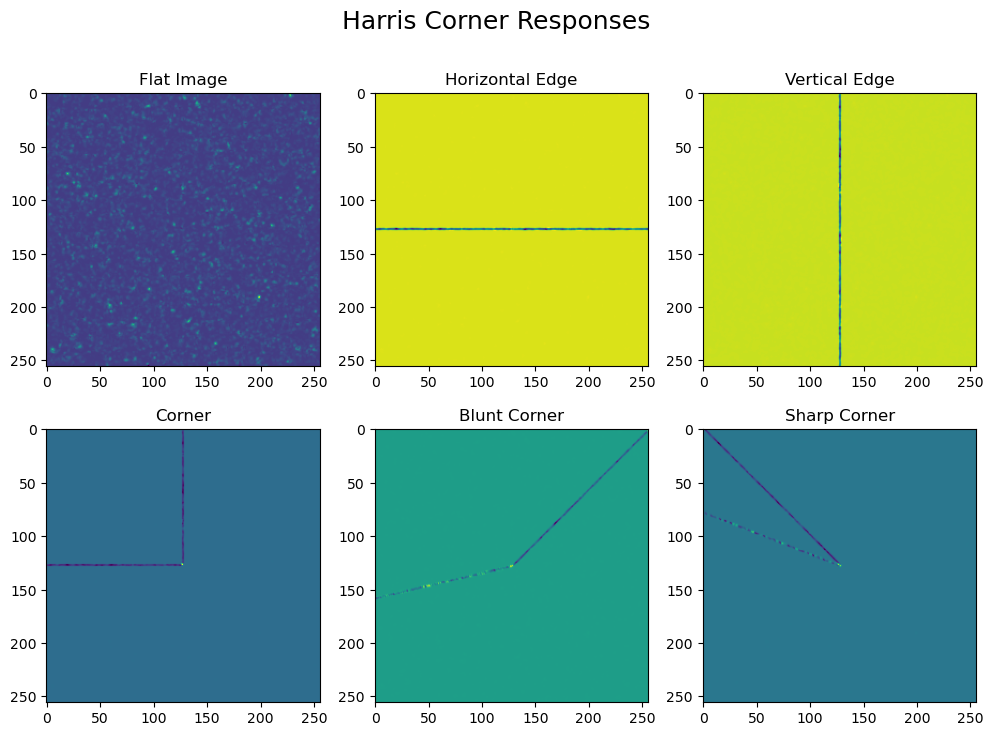

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle("Harris Corner Responses", size=18)

ax[0, 0].imshow(R_flat)
ax[0, 0].set_title("Flat Image")

ax[0, 1].imshow(R_horz)
ax[0, 1].set_title("Horizontal Edge")

ax[0, 2].imshow(R_vert)
ax[0, 2].set_title("Vertical Edge")

ax[1, 0].imshow(R_corner)
ax[1, 0].set_title("Corner")

ax[1, 1].imshow(R_blunt_corner)
ax[1, 1].set_title("Blunt Corner")

ax[1, 2].imshow(R_sharp_corner)
ax[1, 2].set_title("Sharp Corner")

In [9]:
R_horz.min()

-2.931416242248139

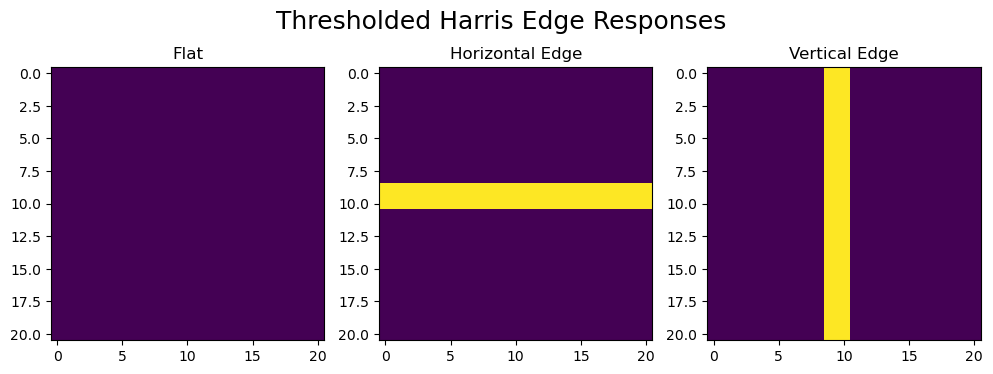

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Thresholded Harris Edge Responses", size=18)

# get slice window
w_sz = 10
s = slice(N//2-w_sz,N//2+w_sz+1)

ax[0].imshow((R_flat < -thresh)[s,s])
ax[0].set_title("Flat")

ax[1].imshow((R_horz < -thresh)[s,s])
ax[1].set_title("Horizontal Edge")

ax[2].imshow((R_vert < -thresh)[s,s])
ax[2].set_title("Vertical Edge");

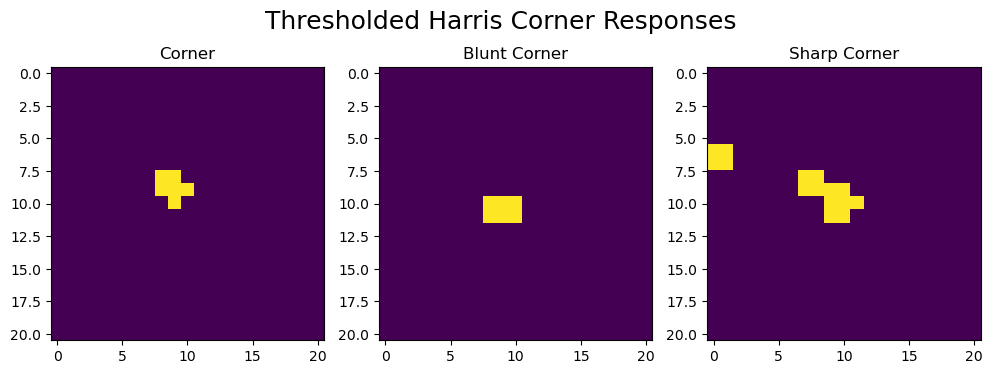

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.suptitle("Thresholded Harris Corner Responses", size=18)

# get slice window
w_sz = 10
s = slice(N//2-w_sz,N//2+w_sz+1)

ax[0].imshow((R_corner > thresh)[s,s])
ax[0].set_title("Corner")

ax[1].imshow((R_blunt_corner > thresh)[s,s])
ax[1].set_title("Blunt Corner")

ax[2].imshow((R_sharp_corner > thresh)[s,s])
ax[2].set_title("Sharp Corner");

In [23]:
dx = cv2.filter2D(vert_image, ddepth=-1, kernel=Sx)
dy = cv2.filter2D(vert_image, ddepth=-1, kernel=Sy)

# place window around center of image
w_sz = 20
s = slice(N//2-w_sz,N//2+w_sz+1)
dx_win = dx[s, s]
dy_win = dy[s, s]

# center data
dx_win -= dx_win.mean()
dy_win -= dy_win.mean()

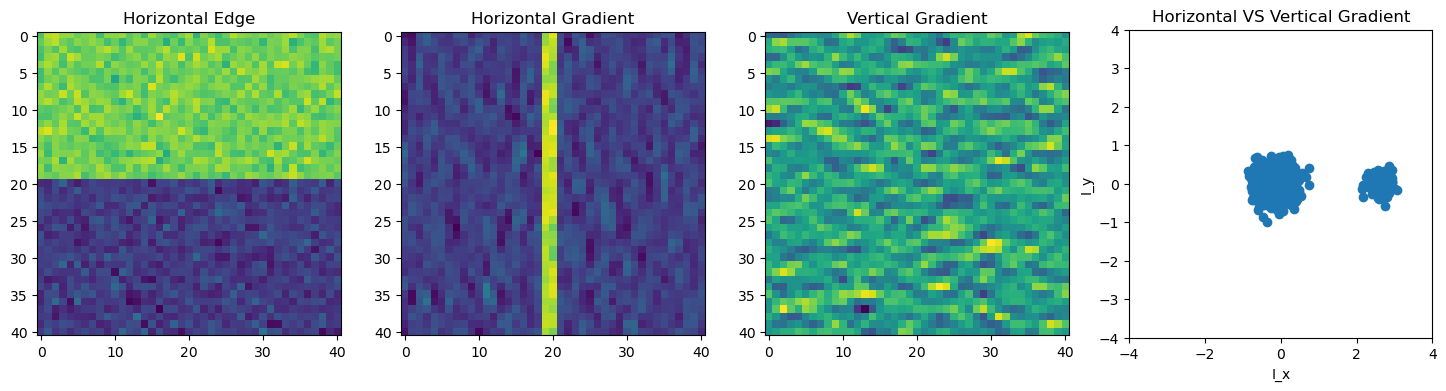

In [21]:
from matplotlib.patches import Ellipse


fig, ax = plt.subplots(1, 4, figsize=(18, 4))
ax[0].imshow(horz_image[s, s])
ax[0].set_title("Horizontal Edge")
ax[1].imshow(dx_win)
ax[1].set_title("Horizontal Gradient")
ax[2].imshow(dy_win)
ax[2].set_title("Vertical Gradient");

# # wing an ellipse
# ellipse = Ellipse(xy=(0,0), width=2.25, height=8.0, angle=0, color='r', alpha=0.25)
# ax[3].add_artist(ellipse)

ax[3].scatter(dx_win.flatten(), dy_win.flatten())
ax[3].set_xlim(-4, 4)
ax[3].set_ylim(-4, 4)
ax[3].set_title("Horizontal VS Vertical Gradient")
ax[3].set_xlabel("I_x")
ax[3].set_ylabel("I_y");

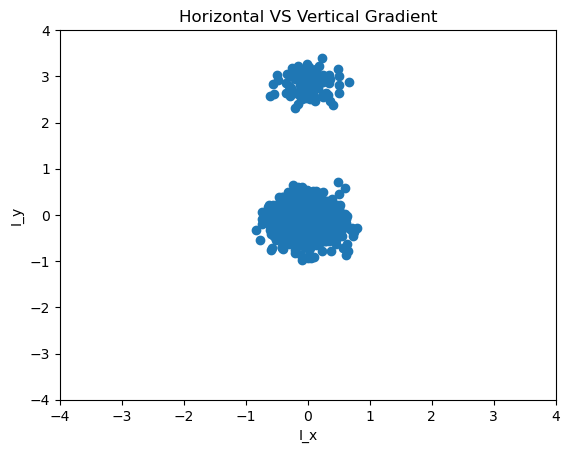

In [17]:
plt.scatter(dx_win.flatten(), dy_win.flatten())
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.title("Horizontal VS Vertical Gradient")
plt.xlabel("I_x")
plt.ylabel("I_y");

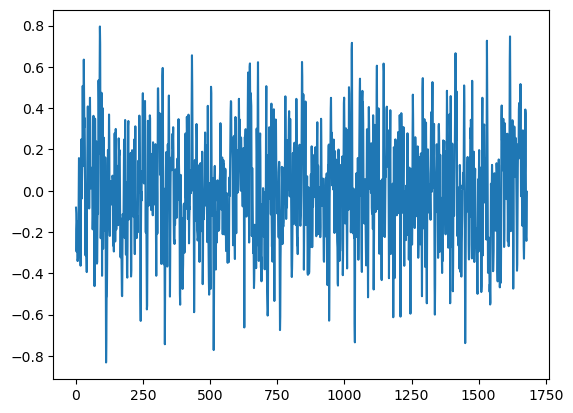

In [18]:
plt.plot(dx_win.T.flatten())

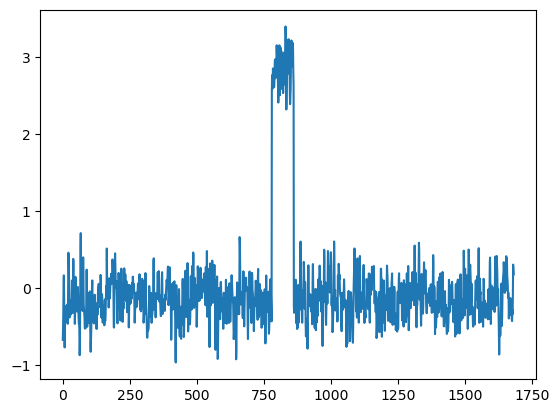

In [19]:
plt.plot(dy_win.flatten())

### **Study Eigenvalues of M matrix at the center pixels**

In [30]:
test_images = {
    'Flat Image' : flat_image,
    'Horizontal Edge' : horz_image,
    'Vertical Edge' : vert_image,
    'Corner' : corner,
    'Blunt Corner' : blunt_corner,
    'Sharp Corner' : sharp_corner
}

Flat Image : 0.11 0.41
Horizontal Edge : 0.01 5.47
Vertical Edge : 6.28 0.02
Corner : 4.63 1.70
Blunt Corner : 0.17 1.87
Sharp Corner : 0.56 6.53


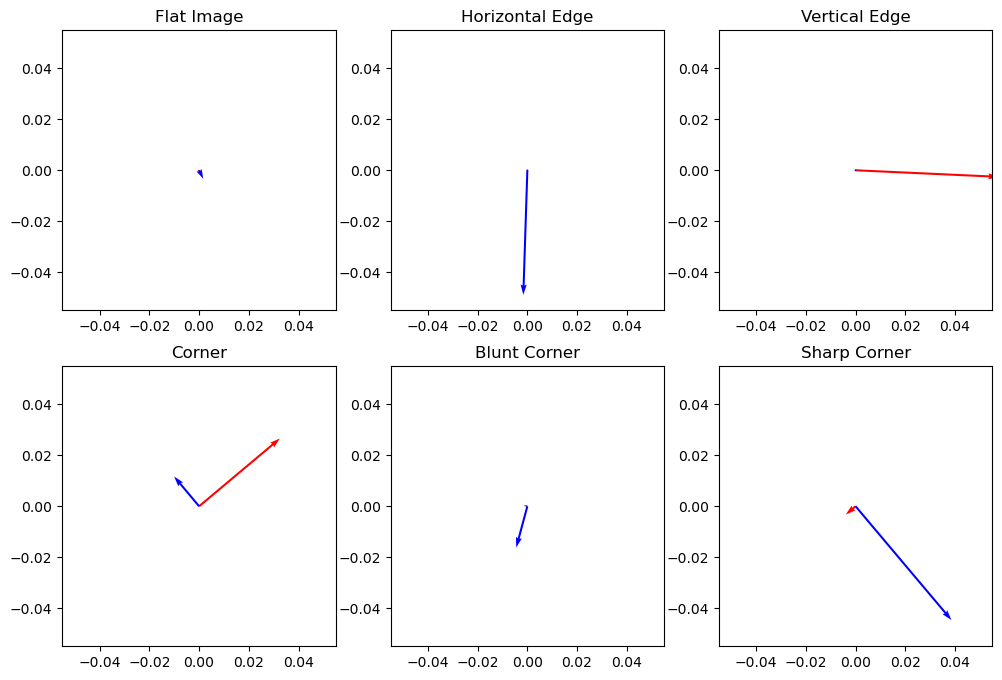

In [31]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

x, y = N//2 - 1, N//2 - 1

for i, (k, img) in enumerate(test_images.items()):
    dx = cv2.filter2D(img, ddepth=-1, kernel=Sx)
    dy = cv2.filter2D(img, ddepth=-1, kernel=Sy)

    A = cv2.filter2D(dx*dx, ddepth=-1, kernel=G)
    B = cv2.filter2D(dy*dy, ddepth=-1, kernel=G)
    C = cv2.filter2D(dx*dy, ddepth=-1, kernel=G)

    M = np.array([[A[x, y], C[x, y]],
                  [C[x, y], B[x, y]]])

    # compute eigenvalues
    (alpha, beta), v = np.linalg.eig(M)
    print(f"{k} : {alpha:.2f} {beta:.2f}")

    # (OPTIONAL) get plot values
    a = np.insert(v, [0,1], np.array([0,0]), axis=1)[0, :]
    b = np.insert(v, [0,1], np.array([0,0]), axis=1)[1, :]

    if i < 3:
        ax[0, i].quiver(*[0, 0], *v[:,0]*alpha, color=['r'], scale=12)
        ax[0, i].quiver(*[0, 0], *v[:,1]*beta, color=['b'], scale=12)
        ax[0, i].set_title(k);
    else:
        ax[1, i-3].quiver(*[0, 0], *v[:,0]*alpha, color=['r'], scale=12)
        ax[1, i-3].quiver(*[0, 0], *v[:,1]*beta, color=['b'], scale=12)
        ax[1, i-3].set_title(k);

Plot ellipses around scatter plots

NOTE: This won't be exact since the M matrix is comprised of products of gradients (dx*dx, dx*dy, dy*dy) and the scatter plot is simply of the gradients. However, the eigenvectors will still describe the general variation of the dx VS dy scatter plots

Flat Image : 0.11 0.41 25.94
0.24839823700625455
Horizontal Edge : 0.01 5.47 -1.85
3.279347243641976
Vertical Edge : 6.28 0.02 177.38
3.7672657538654297
Corner : 4.63 1.70 219.99
2.775785330328147
Blunt Corner : 0.17 1.87 -15.07
1.1239231402502252
Sharp Corner : 0.56 6.53 40.12
3.9153082588019315


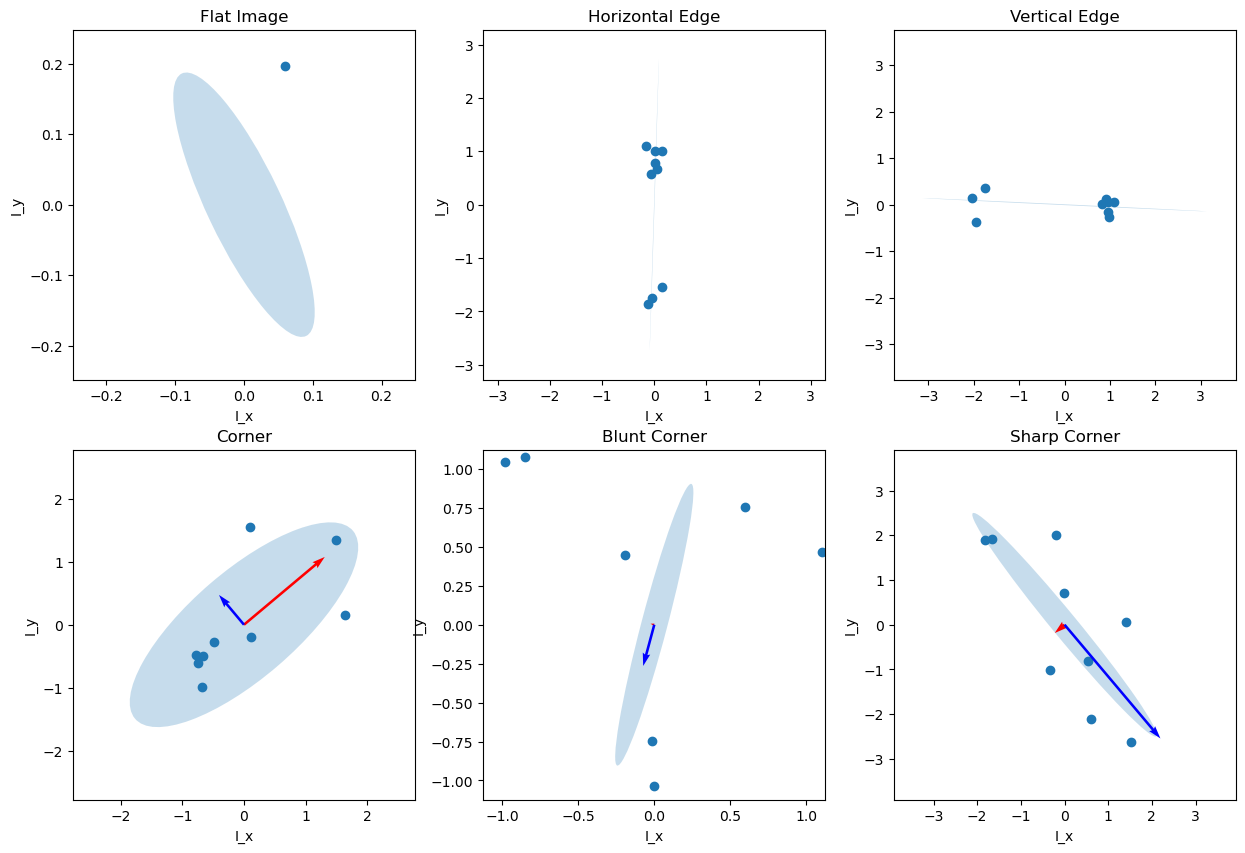

In [32]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

x, y = N//2 - 1, N//2 - 1

t = np.linspace(0, 2*np.pi, 100)

for i, (k, img) in enumerate(test_images.items()):
    dx = cv2.filter2D(img, ddepth=-1, kernel=Sx)
    dy = cv2.filter2D(img, ddepth=-1, kernel=Sy)

    A = cv2.filter2D(dx*dx, ddepth=-1, kernel=G)
    B = cv2.filter2D(dy*dy, ddepth=-1, kernel=G)
    C = cv2.filter2D(dx*dy, ddepth=-1, kernel=G)

    M = np.array([[A[x, y], C[x, y]],
                  [C[x, y], B[x, y]]])

    (alpha, beta), v = np.linalg.eig(M)

    t2 = np.degrees(np.arctan2(v[:, 1][1], v[:, 1][0]))
    theta = 90 + t2
    print(f"{k} : {alpha:.2f} {beta:.2f} {theta:.2f}")

    # get xy limits
    l = np.max([np.abs(alpha), np.abs(beta)]) * 0.6
    print(l)

    # place window around center of image
    w_sz = 1
    s = slice(N//2-w_sz,N//2+w_sz+1)
    dx_win = dx[s, s]
    dy_win = dy[s, s]

    # center data
    dx_win -= dx_win.mean()
    dy_win -= dy_win.mean()


    if i < 3:
        ellipse = Ellipse(xy=(0,0), width=alpha, height=beta, angle=theta, alpha=0.25)
        ax[0, i].add_artist(ellipse)
        ax[0, i].scatter(dx_win.flatten(), dy_win.flatten())
        ax[0, i].set_title(k)
        ax[0, i].set_xlim(-l, l)
        ax[0, i].set_ylim(-l, l)
        ax[0, i].set_xlabel("I_x")
        ax[0, i].set_ylabel("I_y")
    else:
        ellipse = Ellipse(xy=(0,0), width=alpha, height=beta, angle=theta, alpha=0.25)
        ax[1, i-3].add_artist(ellipse)
        ax[1, i-3].scatter(dx_win.flatten(), dy_win.flatten())
        ax[1, i-3].quiver(*[0, 0], *v[:,0]*alpha, color=['r'], scale=15)
        ax[1, i-3].quiver(*[0, 0], *v[:,1]*beta, color=['b'], scale=15)
        ax[1, i-3].set_xlim(-l, l)
        ax[1, i-3].set_ylim(-l, l)
        ax[1, i-3].set_xlabel("I_x")
        ax[1, i-3].set_ylabel("I_y")
        ax[1, i-3].set_title(k);